# Automated News Update, or, "Dwyer's attempt at automating himself out of a job"

### To Do
* Fix Detroit News
* Functionality to add news article to SQL database after the fact
* Add Phys.org
* Add infinite scrolling functionality to css_scraypuh

### Can't because of paywalls:
* WSJ
* Nikkei
* Automotive World

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import packages, define important stuff

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import datetime as dt
import time

import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from bs4 import BeautifulSoup, SoupStrainer
from selenium import webdriver
import requests

import docx
from docx.enum.text import WD_COLOR_INDEX
from docx.shared import Pt
from docx.shared import Inches

import random

!pip install nltk
import nltk
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EBarnard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Keyword lists for each of the different news updates
CAV_keywords = ['self-driving', 'automated', 'self driving', 'autonomous', 'MaaS', 'ride-sharing', 'ridesharing', 'ride-hailing',
                'ridehailing', 'lidar', 'LiDAR', 'rideshare', 'ridehail', 'ride-hail', 'ridesource', 'ride-source', 'ride-sourcing',
                'carsharing', 'car-sharing', 'carshare', 'car-share', 'Uber', 'Lyft', 'Chariot', 'connected car', 'Waymo', 'TRI',
                'Cruise', 'Zoox', 'Mobileye', 'Softbank', 'peer-to-peer', 'Turo']
AFV_keywords = ['rare-earth', 'rare earth', 'natural gas', 'electric vehicle', 'electric car', 'EV', 'electrification', 'alternative fuel', 'CNG', 'LNG',
                'alt-fuel', 'propane', 'charging station', 'EVSE', 'electric vehicle charging', 'HEV', 'hybrid', 'hybrid-electric', 'plug-in', 'PHEV', 
                'electric motor', 'bio-fuel', 'biofuel', 'idle reduction', 'fuel cell', 'electric bus', 'electric truck', 'electric drive',
                'battery-electric', 'battery electric', 'battery-electric-powered', 'regenerative braking']
truck_keywords = ['alternative fuel', 'natural gas', 'compressed natural gas', 'liquefied natural gas', 'CNG', 'LNG', 'propane', 'LPG', 'dimethyl ether', 'DME', 'electric', 'electricity', 'electrified', 'electric drive',
                  'battery', 'energy storage', 'hydrogen', 'fuel cell', 'hybrid', 'hybrid electric', 'hybrid hydraulic', ' Phase 2', 'Phase II', 'efficiency', 'fuel efficiency', 'fuel economy', 'aftertreatment',
                  'emission control', 'diesel particulate filter', 'DPF', 'selective catalytic reduction', 'SCR', 'aerodynamics', 'sustainability', 'waste heat recovery', 'Rankine', 'organic Rankine', 'SuperTruck',
                  'automated manual', 'AMT', 'platooning', 'lithium', 'biofuel', 'fast charging', 'downspeed', 'downsize', 'clean diesel', 'turbocompound', 'rolling resistance', 'skirt', 'boat tail', 'axle', 'low viscosity',
                  'catenary', 'autonomy', 'autonomous', 'connected and autonomous', 'connected', 'telematics', 'driver assist', 'CACC', 'active cruise control', 'crash avoidance', 'crashworthiness', 'weigh-in-motion', 'weigh in motion',
                  'high productivity', 'truck size and weight', 'V2I', 'V2V', 'vehicle to infrastructure', ' vehicle to vehicle',  'restructuring', 'acquisition', 'driver cost', 'operational efficiency',
                  'facilities', 'proving ground', 'partnership', 'regional haul', 'joint venture', 'grant', 'FOA', 'funding opportunity', 'unveil', 'announce', 'offer', 'expansion', 'greenhouse gas', 'GHG', 'emission regulation',
                  'emissions regulation', 'idle', 'idling', 'zero emissions', 'strategic plan', 'SmartWay', 'VIUS', 'well to wheels', 'pump to wheels', 'well to pump', 'CARB', 'CEC', 'air resources board', 'energy commission', 'EPA',
                  'Environmental Protection Agency', 'smart mobility', 'smart cities']
Hyperloop_keywords = ['hyperloop', 'high-speed train',
                      'high speed train', 'bullet train', 'ET3']

# Drop articles if any of these words are in the article title. Not case sensitive.
CAV_bad_words = []
AFV_bad_words = ["Today's Car News", 'image', 'picture', 'podcast', 'video', 'photo', 'tweet']
truck_bad_words = []
Hyperloop_bad_words = []

# Used for diagnostics/tracking later
scrape_specs = {}

# Set day of week for each scraper category, to reduce run time (avoid searching for all keyword lists every run)
scraper_sched = {'CAV': 0, 'AFV': 2, '21CTP': 4, 'Hyperloop': 0}

# Ideal number of articles to be scraped for each scraper
ideal_no_articles = {'AFV': 50, 'CAV': 40, '21CTP': 35, 'Hyperloop': 35}

# Age filter, in days (only want to pull articles that are <= 1 week old)
max_age = 7

# For file naming and tracking
search_date = dt.date.today()

# testing:
#test_date_str = '02/27/2019'
#search_date = dt.datetime.strptime(test_date_str, '%m/%d/%Y').date()

search_date_str = str(search_date)

# Needed for web scraping "browser"
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}

# For database update; ensures duplicates aren't loaded
db_update = False

# Maximum number of sentences to be scraped for each article pulled.
max_sentences = 5

In [5]:
# scraped_count = 0
# skip_count = 0
# too_old = 0
# iteration = 0
# skip_ind = []
# old_ind = []


def replace_em(text):
    '''Replaces odd characters in text. Used for page titles and summaries'''
    bad_chars = ['â€œ', 'â€™', 'â€�', '\n', 'Â',
                 'â€”', '(earlier post)', 'â€?', '\t', 'â€œ', '(TNS) — ', '(Reuters) - ',
                 'DUBAI (Reuters) - ', '(adsbygoogle = window.adsbygoogle || []).push({});']
    for bad_char in bad_chars:
        text = text.replace(bad_char, '')
    return text

def clean_summary(par_list):
    # Clean article paragraphs and join them into one block of text
    all_text = replace_em(' '.join(par.text for par in par_list)) 
    # Split the article text up into sentences
    sentence_list = tokenizer.tokenize(all_text)
    # If the number of sentences is greater than max_sentences, return the first max_sentences sentences.
    if len(sentence_list) > max_sentences:
        return ' '.join([sentence.strip() for sentence in sentence_list[0:max_sentences]])
    # Otherwise, return all sentences.
    else:
        return ' '.join([sentence.strip() for sentence in sentence_list])

def grab_homepage(url):
    '''Creates BeautifulSoup object using input url'''
#     headers = {'user-agent': 'Mozilla/5.0'}
    page_1 = requests.get(url, headers=headers)
    return BeautifulSoup(page_1.content, "html5lib")


def print_results(site, scraped_count, skip_count, too_old, df, duration, scrape_specs):
    '''Prints out a quick summary of one website's full scraping and adds summary specs to scrape_specs dictionary'''
    print(f'{scraped_count} {site} article(s) scraped')
    print(f'{skip_count} {site} article(s) skipped due to error')
    print(f'{too_old} {site} article(s) skipped due to age')
    print(f'{df.shape[0]} relevant article(s) collected')
    scrape_specs[f"{site}"] = {'Pages Scraped': scraped_count, 'Relevant Articles': df.shape[0], 'Errors': skip_count,
                               'Too old': too_old, 'Time spent': duration}
    return scrape_specs


def page_scan(title, summary, url, date, source):
    '''
    Searches a web page title and summary for keywords; returns the dictionary object that is used to create 
    the final dataframe. Searches the title first; if the keyword is there, it doesn't search the summary.

    Only searches for keywords specific to that day of the week's news update.
    '''
    bool_dict = {'Hyperloop': 0, 'CAV': 0, 'AFV': 0, '21CTP': 0}
    title_scrape = title+' '+title.lower()
    summary_scrape = summary+' '+summary.lower()

    if search_date.weekday() == scraper_sched['CAV']:
        if any(keyword in title_scrape for keyword in CAV_keywords):
            bool_dict['CAV'] = 1
        elif any(keyword in summary_scrape for keyword in CAV_keywords):
            bool_dict['CAV'] = 1

    if search_date.weekday() == scraper_sched['Hyperloop']:
        if any(keyword in title_scrape for keyword in Hyperloop_keywords):
            bool_dict['Hyperloop'] = 1
        elif any(keyword in summary_scrape for keyword in Hyperloop_keywords):
            bool_dict['Hyperloop'] = 1

    if search_date.weekday() == scraper_sched['AFV']:
        if any(keyword in title_scrape for keyword in AFV_keywords):
            bool_dict['AFV'] = 1
        elif any(keyword in summary_scrape for keyword in AFV_keywords):
            bool_dict['AFV'] = 1

    if search_date.weekday() == scraper_sched['21CTP']:
        if any(keyword in title + title_scrape for keyword in truck_keywords) & (('truck' in title_scrape) | ('trucks' in title_scrape)):
            bool_dict['21CTP'] = 1
        elif any(keyword in summary_scrape for keyword in truck_keywords) & (('truck' in summary_scrape) | ('trucks' in summary_scrape)):
            bool_dict['21CTP'] = 1

    if sum(bool_dict.values()) > 0:
        return {'title': title.strip(), 'summary': summary.strip(), 'link': url, 'source': source,
                'date': date, 'AFV': bool_dict['AFV'], 'CAV': bool_dict['CAV'], '21CTP': bool_dict['21CTP'],
                'Hyperloop': bool_dict['Hyperloop']}
    else:
        return 'Most definitely nope'

# The following two functions are for the Word document output!


def add_hyperlink(paragraph, url, text):
    '''
    :param paragraph: The paragraph we are adding the hyperlink to.
    :param url: A string containing the required url
    :param text: The text displayed for the url
    :return: The hyperlink object
    '''
    # This gets access to the document.xml.rels file and gets a new relation id value
    part = paragraph.part
    r_id = part.relate_to(
        url, docx.opc.constants.RELATIONSHIP_TYPE.HYPERLINK, is_external=True)

    # Create the w:hyperlink tag and add needed values
    hyperlink = docx.oxml.shared.OxmlElement('w:hyperlink')
    hyperlink.set(docx.oxml.shared.qn('r:id'), r_id, )

    # Create a w:r element
    new_run = docx.oxml.shared.OxmlElement('w:r')

    # Create a new w:rPr element
    rPr = docx.oxml.shared.OxmlElement('w:rPr')

    # bold the text
    u = docx.oxml.shared.OxmlElement('w:b')
    rPr.append(u)

    # Join all the xml elements together add add the required text to the w:r element
    new_run.append(rPr)
    new_run.text = text
    hyperlink.append(new_run)

    paragraph._p.append(hyperlink)

    return hyperlink


def gen_docx(newstype, graph_bool = False, dwyer=True):
    '''
    Generates news Word doc using data file from web scrape
    :param newstype: Either "21CTP", "CAV", or "AFV"
    :param dwyer: If not running on Dwyer's computer, set this to False and put all needed files in the same directory
    '''
    
    # select data file (xls) based on the newstype and date. Note that search_date_str is a global variable defined outside
    # of this function. Each news update only happens once a week --> only one xls file per newstype per week --> can't just
    # pick any old search_date_str and make a file.
    if dwyer:
        #Name of the excel file (standardized)
        data_file = f"{newstype.lower()}_news_updates/{search_date_str}_{newstype}_news_download.xls"
    else:
        data_file = f"{search_date_str}_{newstype}_news_download.xls"
    #data_file = "C:\\Users\\EBarnard\\OneDrive - VSE Corporation\\Research\\General Research\\Misc Transportation\\EV News Webscraper\\GitHub\\Mike's webscraper\\cav_news_updates\\2019-03-04_cav_news_download.xls"
    # Read the data in from the selected file
    df = pd.read_excel(data_file)
    df.reset_index(drop = True, inplace = True)
    df.category = df.category.astype('int64') # Cast category column to int
    section_dict = {'Business and Market Analysis': df[df.category == 1].T.to_dict(), 
                    'Technology, Testing, and Analysis': df[df.category == 2].T.to_dict(), 
                    'Policy and Government':df[df.category == 3].T.to_dict()}

    # Start creating the word doc
    newsdoc = docx.Document(docx='python_docx.docx')

    # Add up-front stuff - title, headers, and for the AFV update, some other stuff (two captions and some text)
    if newstype == 'AFV':
        newsdoc.add_heading(
            f"Alternative Fuel Vehicle Weekly News Update – {search_date.strftime('%m/%d/%Y')}", 0)
        newsdoc.add_heading('EVSE Market Analysis', 1)
        # Add EVSE bar chart if graph_bool is true
        if graph_bool:
            evse_bar_chart = EVSE_file_dict['EVSE_bar_chart']
            newsdoc.add_paragraph().add_run().add_picture(evse_bar_chart, width=Inches(6.0))
            CA_nums = EVSE_file_dict['CA_shares'] # Adjust this to actual string with numbers.  Read string in from CSV
        # Otherwise create a placeholder where the graph can be added by hand
        else:
            evse_bar_chart = newsdoc.add_paragraph().add_run('INSERT EVSE BAR CHART HERE')
            evse_bar_chart.font.bold = True
            evse_bar_chart.font.size = Pt(16)
            evse_bar_chart.font.highlight_color = WD_COLOR_INDEX.YELLOW
            CA_nums='NEED TO INSERT' # Default string for the CA EVSE numbers (automatically populates the caption for the EVSE bar chart figure)
        newsdoc.add_paragraph('Figure: Number of EVSE plugs (note: not stations) by state and charging level.'
                              'CA is not included, since it would make the rest of the state numbers illegible.'
                              f"CA holds a disproportionately large share of the total EVSE plugs: {CA_nums} "
                              'of Level 1, Level 2, and DCFC plugs respectively. Data Source: U.S. DOE AFDC Station Locator.',
                              style='Caption')
        newsdoc.add_paragraph(' ')
        newsdoc.add_paragraph('The table below summarizes overall changes in number of EV charging stations by state between '
                              f"{(search_date - dt.timedelta(7)).strftime('%m/%d/%Y')} and {search_date.strftime('%m/%d/%Y')}:",
                              style='Normal')
        newsdoc.add_paragraph('Table 1: Change in number of EV charging stations by state, between '
                              f"{(search_date - dt.timedelta(7)).strftime('%m/%d/%Y')} and {search_date.strftime('%m/%d/%Y')}",
                              style='Caption')
        evse_delta_table = newsdoc.add_paragraph().add_run('INSERT EVSE DELTA TABLE HERE')
        evse_delta_table.font.bold = True
        evse_delta_table.font.size = Pt(16)
        evse_delta_table.font.highlight_color = WD_COLOR_INDEX.YELLOW

    if newstype == 'CAV':
        newsdoc.add_heading(
            f"Connected and Automated Vehicle Weekly News Update – {search_date.strftime('%m/%d/%Y')}", 0)
        newsdoc.add_paragraph(' ')
        newsdoc.add_paragraph('Includes coverage of ride-sharing and other smart mobility technologies. '
                              'The majority of this is direct quotations from the respective articles. I '
                              'claim none of this text content as my own, having only sifted through the '
                              'web to find already-existing pieces relevant to these topics.')

    if newstype == '21CTP':
        newsdoc.add_heading(
            f"21CTP Trucking Weekly News Update – {search_date.strftime('%m/%d/%Y')}", 0)

    for header in section_dict:
        newsdoc.add_heading(header, 1)
        for row in section_dict[header]:
            row = section_dict[header][row]
            newsdoc.add_heading(row['title'], level=2)
            p = newsdoc.add_paragraph(row['summary'] + ' ')
            p.add_run('(')
            # This is where the add_hyperlink function is used
            add_hyperlink(p, '{}'.format(row['link']), '{}'.format(row['source']))
            p.add_run(')')
        newsdoc.add_paragraph('')
            
    if newstype == 'CAV':
        newsdoc.add_heading('Relevant Transportation Research', 1)
        newsdoc.add_paragraph('This section includes publications, papers, articles, and conferences that investigate and/or'
                              'discuss transportation and travel demand impacts of MaaS or other “future travel” considerations.'
                              'Portions of the abstract or description (not my words) are included under each title for more information.')
    if newstype == 'AFV':
        newsdoc.add_heading('Relevant Transportation Research', 1)
        newsdoc.add_paragraph('This section includes publications, papers, articles, and conferences that investigate and/or'
                              'discuss alternative fuel vehicle impacts on transportation systems. Portions of the abstract '
                              'or description (not my words) are included under each title for more information.')
    if dwyer:
        filename = f"{newstype.lower()}_news_updates/Energetics {newstype} News Update - {search_date_str}.docx"
        newsdoc.save(filename)
    else:
        filename = f"Energetics {newstype} News Update - {search_date_str}.docx"
        newsdoc.save(filename)
    return filename


def which_keyword_found(row):
    ''' Identifies and stores which keywords triggered the news item pull '''
    words_found = []
    for keyword in CAV_keywords+AFV_keywords+truck_keywords+Hyperloop_keywords:
        try:
            if (row['summary'].find(keyword) > 0) | (row['title'].find(keyword) > 0):
                words_found.append(keyword)
        except:
            continue
    return ', '.join(words_found)


def keyword_pull(string):
    ''' Pulls all relevant capitalized words out of the title, as a quick "keyword" list '''
    not_keywords = ['A', 'New', 'First', 'Group', 'The', 'This', 'I', 'To', 'Who', 'Silicon', 'Valley', 'System', 'Build', 'Payment', 'Business', 'API', 'JV', 'JVs',
                    'European', 'American', 'America', 'Europe', 'China', 'But', 'Are', 'They', 'Legal', 'Says', 'AV', 'Revolution', 'Is',
                    'TechCrunch', 'For', 'EVs', 'Really', 'Get', 'Money', 'Adds', 'We', 'All', 'Starts', 'Return', 'Apart',
                    'Them', 'Cities', 'After', 'Insurance', 'Back', 'Against', 'Would', 'Displace', 'Improves', 'While',
                    'That', 'You', 'Find', 'Along', 'From', 'Their', 'Not', 'So', 'Say', 'Experts', 'Drivers', 'Its', 'Into', 'Fully',
                    'Ranks', 'Stretch', 'SUV', 'Data', 'Sharing', 'Live', 'When', 'Agencies', 'Still', 'Trying', 'Program', 'Offer', 'Four',
                    'Will', 'Backs', 'Just', 'Around', 'Years', 'Its', 'Future', 'Deploying', 'Objects', 'Distance', 'Highlights']
    string = string.replace(';', '').replace(',', '').lstrip().split(' ')
    keywords = [word for word in string if (
        word[0].isupper()) & (word not in not_keywords)]
    return ', '.join(keywords)

### Create a scraper class that will be used for each website

In [6]:
class scraypah:
    '''
    Scraypah is a web scraper that searches through all of the recent articles on a website and extracts key information
    from those that include relevant keywords. It requires a dictionary of parameters specific to each website that needs
    to be scraped. See the __init__ docstring for information on the input parameter requirements.
    '''

    def __repr__(self):
        return "This is an object of class scraypah!"

    def __init__(self, params):
        '''
        Attributes:
            params[url] (str): Homepage of the website, where each of the article page links are extracted from
            params[source] (str): Name of the website
            params[strain_bool] (bool): Is there a soup strainer for this website or not?
            params[strain_tag] (str): Tag used for soup strainer
            params[strain_attr_name] (str): Attribute name used for soup strainer
            params[strain_attr_value] (str): Attribute value used for soup strainer
            params[date_loc] (str): Location of the date in the HTML
            params[date_format] (str): Allows user to set the date format, if the format on the website does not parse automaticall
            params[sum_loc] (str): Location of the summary in the HTML (this is typically the first 3 paragraphs of the article)
            params[title_loc] (str): Location of the title in the HTML
            params[url_list_query] (str): BeautifulSoup code to extract the list of articles from the website homepage(s) (url)
        '''
        self.base_url = params['url']
        self.source = params['source']
        self.strainer = params['strain_bool']
        if self.strainer:
            self.strain_tag = params['strain_tag']
            self.strain_attr_name = params['strain_attr_name']
            self.strain_attr_value = params['strain_attr_value']
        self.date_loc = params['date_loc']
        self.date_format = params['date_format']
        self.sum_loc = params['sum_loc']
        self.title_loc = params['title_loc']
        self.url_list_query = params['url_list_query']

    def get_urls(self):
        '''Populates self.urls_to_scrape with a list of urls extracted from the website homepage(s)'''
        self.urls_to_scrape = []
        with requests.Session() as s:

            # Checks if the base_url is a single url or a list of urls - some websites publish enough articles
            # that we have to pull multiple pages
            if isinstance(self.base_url, str):

                # Checks if there is a "soup strainer" for the website being scraped. See here:
                # https://www.crummy.com/software/BeautifulSoup/bs4/doc/#parsing-only-part-of-a-document
                if not self.strainer:
                    page = requests.get(self.base_url, headers=headers)
                    time.sleep(0.5)
                    self.base_soup = BeautifulSoup(page.content, "lxml")
                else:
                    only_parse = SoupStrainer(self.strain_tag, attrs={
                                              self.strain_attr_name: self.strain_attr_value})
                    self.base_soup = BeautifulSoup(requests.get(
                        self.base_url, headers=headers).content, "lxml", parse_only=only_parse)

                time.sleep(1)
                self.urls_to_scrape = eval(self.url_list_query)

            else:
                for url in list(self.base_url):
                    if not self.strainer:
                        page = requests.get(url, headers=headers)
                        time.sleep(0.5)
                        self.base_soup = BeautifulSoup(page.content, "lxml")
                    else:
                        only_parse = SoupStrainer(self.strain_tag, attrs={
                                                  self.strain_attr_name: self.strain_attr_value})
                        self.base_soup = BeautifulSoup(requests.get(
                            url, headers=headers).content, "lxml", parse_only=only_parse)
                    time.sleep(1)
                    self.urls_to_scrape += eval(self.url_list_query)
        self.urls_to_scrape = list(set(self.urls_to_scrape))

    def scrape_em(self):
        self.relevant_articles = {}
        self.scraped_count = 0
        self.skip_count = 0
        self.too_old = 0
        self.iteration = 0
        self.skip_ind = []
        self.old_ind = []
        for url in self.urls_to_scrape:
            time.sleep(0.2)
            self.iteration += 1
            summary = None
            title = None
            date = None
            try:
                with requests.Session() as s:
                    page = s.get(url, headers=headers)
                    if self.source in ['Semiconductor Engineering', 'Reuters', 'Recode']:
                        article = BeautifulSoup(page.content, "html5lib")
                    else:
                        article = BeautifulSoup(page.content, "lxml")
                    date = pd.to_datetime(eval(self.date_loc).strip().replace(
                        '\\xa0', '').replace(' -\nBy:', ''), format=self.date_format).date()
                    if (date - search_date).days >= -max_age:
                        summary = clean_summary(eval(self.sum_loc)) # Assumes that eval(...) results in a list of paragraphs.
                        title = eval(self.title_loc).replace('â€™', "'").replace(
                            '\\xa0', ' ').replace('\\n', '').lstrip().replace('  ', '')
                        temp = page_scan(title, summary, url,
                                         date, self.source)
                        if temp != 'Most definitely nope':
                            self.relevant_articles[self.scraped_count] = temp
                        self.scraped_count += 1
                    else:
                        self.too_old += 1
                        self.old_ind.append(self.iteration-1)
            except Exception as exc:
                print(
                    f"{str(exc)}: {url} \ndate:{date}\ntitle:{title}\nsummary:{summary}")
                self.skip_count += 1
                self.skip_ind.append(self.iteration-1)
                continue
        self.relevant_df = pd.DataFrame.from_dict(self.relevant_articles).T
        if not self.relevant_df.empty:
            self.relevant_df.drop_duplicates('link', inplace=True)

### Set parameters for each website scraper

In [7]:
# 'article' is the variable that stores the BeautifulSoup soup for a particular article page. e.g. "energy.gov/some-article."
# The values of date_loc, sum_loc, and title_loc should be the BeautifulSoup commands for accessing the date location, 
# summary location and title location, respectively.
# News sources are rated from 1-3 (1-Best, 3-Worst)

scraper_dict = {'MIT': {'url': 'http://news.mit.edu/mit-news',
                        'source': 'MIT',
                        'strain_tag': 'ul',
                        'strain_attr_name': 'class',
                        'strain_attr_value': 'view-mit-news clearfix',
                        'url_list_query': "['http://news.mit.edu'+item.a['href'] for item in self.base_soup.find('ul', class_='view-mit-news clearfix').find_all('li')]",
                        'date_loc': "article.find('span', attrs={'itemprop':'datePublished'}).text",
                        'date_format': None,
                        'sum_loc': "article.find('div', attrs={'class': 'field-item even'}).find_all('p')",
                        'title_loc': "article.find('h1', attrs={'class':'article-heading'}).text",
                        'strain_bool': True,
                        'rating': 1,
                       },
                'Semiconductor Engineering': {'url': 'http://semiengineering.com/category-main-page-iot-security/',
                           'source': 'Semiconductor Engineering',
                           'strain_tag': 'div',
                           'strain_attr_name': 'class',
                           'strain_attr_value': 'l_col',
                           'url_list_query': "[item['href'] for item in self.base_soup.find('div', class_='l_col').find_all('a', href=True,title=True)]",
                           'date_loc': "article.find('div',class_='loop_post_meta').contents[0]",
                           'date_format': None,
                           'sum_loc': "article.find('div', class_='post_cnt post_cnt_first_letter').find_all('p')[1:4]",
                           'title_loc': "article.find('h1', class_='post_title').text",
                           'strain_bool': True,
                           'rating': 1},
                
                'Quartz': {'url': 'https://qz.com/search/self-driving',
                           'source': 'Quartz',
                           'url_list_query': "['https://qz.com' + a['href'] for a in self.base_soup.find_all('a', class_='_5ff1a')]",
                           'date_loc': "article.time.text",
                           'date_format': None,
                           'sum_loc': "article.find_all('p')[:3]",
                           'title_loc': "article.h1.text",
                           'strain_bool': False,
                           'rating': 2},
                            # Note: member exclusive articles for Quartz will be skipped.
                'Recode': {'url': 'https://www.recode.net/',
                           'source': 'Recode',
                           'strain_tag': 'a',
                           'strain_attr_name': 'data-analytics-link',
                           'strain_attr_value': 'article',
                           'url_list_query': "[item['href'] for item in self.base_soup.find_all('a', attrs={'data-analytics-link':'article'})]",
                           'date_loc': "article.time.text.replace('\\n', '')",
                           'date_format': None,
                           'sum_loc': "article.find_all('p')",
                           'title_loc': "article.h1.text",
                           'strain_bool': True,
                           'rating': 2},
                'GovTech': {'url': 'http://www.govtech.com/fs/transportation/',
                            'source': 'GovTech',
                            'url_list_query': "[item.a['href'] for item in self.base_soup.find_all(class_=['sub-feature-article','feature-article'])]",
                            'date_loc': "article.find('span', class_='date').text.strip()",
                            'date_format': None,
                            'sum_loc': "[item for item in article.find(class_='col-md-10').find_all('div') if len(str(item)) > 12] \
                                        if len([item for item in article.find(class_='col-md-10').find_all('p')]) < 3 \
                                        else [item for item in article.find(class_='col-md-10').find_all('p')]",
                            'title_loc': "article.find('h1').text.strip()",
                            'strain_bool': False,
                            'rating': 1},
                'Reuters': {'url': ['https://www.reuters.com/news/technology',
                                    'https://www.reuters.com/news/archive/technologynews?view=page&page=2',
                                    'https://www.reuters.com/news/archive/technologynews?view=page&page=3',
                                    'https://www.reuters.com/news/archive/technologynews?view=page&page=4',
                                    'https://www.reuters.com/news/archive/technologynews?view=page&page=5'],
                            'source': 'Reuters',
                            'url_list_query': "['https://www.reuters.com'+item.a['href'] for item in self.base_soup.find_all('div', class_='story-content')]",
                            'date_loc': "article.find('div', attrs={'class':'ArticleHeader_date'}).text.split('/')[0]",
                            'date_format': None,
                            'sum_loc': "article.find('div', attrs={'class':'StandardArticleBody_body'}).find_all('p')",
                            'title_loc': "article.h1.text",
                            'strain_bool': False,
                            'rating': 2},
                'CityLab': {'url': 'https://www.citylab.com/transportation/',
                            'source': 'CityLab',
                            'strain_tag': ['h2', 'h1'],
                            'strain_attr_name': 'class', 'strain_attr_value': ['c-promo__hed', 'c-river-item__hed c-river-item__hed--'],
                            'url_list_query': "[item.a['href'] for item in self.base_soup.find_all(['h1','h2'], class_=['c-promo__hed','c-river-item__hed c-river-item__hed--'])]",
                            'date_loc': "article.time.text",
                            'date_format': None,
                            'sum_loc': "article.find_all('p')[1:]",
                            'title_loc': "article.h1.text",
                            'strain_bool': True,
                            'rating': 1},
                'Autoblog': {'url': ['https://www.autoblog.com/archive/']
                                     + ['https://www.autoblog.com/archive/pg-' + str(i) for i in range(2,6)],
                             'source': 'Autoblog',
                             'strain_tag': 'h6',
                             'strain_attr_name': 'class',
                             'strain_attr_value': 'record-heading',
                             'url_list_query': "['https://www.autoblog.com' + header.a['href'] for header in self.base_soup.find_all('h6', class_ = 'record-heading')]",
                             'date_loc': "article.find('div', class_='post-date').text.strip().split(' at')[0]",
                             'date_format': None,
                             'sum_loc': "article.find('div', attrs={'class':'post-body'}).find_all('p')",
                             'title_loc': "article.h1.text",
                             'strain_bool': True,
                             'rating': 3},
                'Electrek': {'url': ['https://electrek.co/'] + 
                                     ['https://electrek.co/page/' + str(i) for i in range(2,6)],
                             'source': 'Electrek',
                             'strain_tag': 'h1',
                             'strain_attr_name': 'class', 'strain_attr_value': 'post-title',
                             'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h1', class_='post-title')]",
                             'date_loc': "article.find('p', class_='time-twitter').text",
                             'date_format': None,
                             'sum_loc': "article.find('div', class_='post-body').find_all('p')[1:]",
                             'title_loc': "article.find('h1', class_='post-title').text",
                             'strain_bool': True,
                             'rating': 3},
                'The Verge': {'url': 'https://www.theverge.com/transportation',
                              'source': 'The Verge',
                              'strain_tag': 'h2',
                              'strain_attr_name': 'class', 'strain_attr_value': 'c-entry-box--compact__title',
                              'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h2', class_='c-entry-box--compact__title')]",
                              'date_loc': "article.time.text",
                              'date_format': None,
                              'sum_loc': "article.find_all('p')",
                              'title_loc': "article.h1.text",
                              'strain_bool': True,
                              'rating': 2},
                'Crunchbase': {'url': 'https://news.crunchbase.com/',
                               'source': 'Crunchbase',
                               'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h2',class_=['entry-title h3','entry-title h5'])]",
                               'date_loc': "article.find('div', class_='meta-item herald-date').text",
                               'date_format': None,
                               'sum_loc': "article.find('div', class_='entry-content herald-entry-content').find_all('p')[1:]",
                               'title_loc': "article.find('h1', class_='entry-title h1').text",
                               'strain_bool': False,
                               'rating': 3},
                'Truck News': {'url': ['https://www.trucknews.com/news',
                                       'https://www.trucknews.com/news/page/2/'],
                               'source': 'Truck News',
                               'url_list_query': "[item.a['href'] for item in self.base_soup.find('ul', class_='media-list').find_all('h4')]",
                               'date_loc': "article.find('div', class_ = 'well').find('p').text.split('by')[0].strip()",
                               'date_format': None,
                               'sum_loc': "article.find('div', class_ = 'the-content').find_all('p')",
                               'title_loc': "article.find('h2').text.strip()",
                               'strain_bool': False,
                               'rating': 3},
                'Trucks.com': {'url': ['https://www.trucks.com/category/news/tech/autonomous-vehicles/',
                                       'https://www.trucks.com/category/editors-picks/'],
                               'source': 'Trucks.com',
                               'url_list_query': "[item.find(['h2','div'], attrs={'class':['title','h4']}).a['href'] for item in self.base_soup.find_all('div', attrs={'class':['content-block','cb-meta container-page-trucks']})]",
                               'date_loc': "article.find('div',class_='date-author').text.strip().split(' by')[0]",
                               'date_format': None,
                               'sum_loc': "article.find('section', attrs={'itemprop':'articleBody'}).find_all('p', attrs={'class':None})",
                               'title_loc': "article.h1.text",
                               'strain_bool': False,
                               'rating': 2},
                'TechCrunch': {'url': ['https://techcrunch.com/', 
                                       'https://techcrunch.com/page/2/', 
                                       'https://techcrunch.com/page/3/', 
                                       'https://techcrunch.com/page/4/'], 
                               'source': 'TechCrunch',
                               'strain_tag': 'a',
                               'strain_attr_name': 'class',
                               'strain_attr_value': 'post-block__title__link',
                               'url_list_query': "[item['href'] for item in self.base_soup.find_all('a', class_='post-block__title__link')]",
                               'date_loc': "url[23:33]",
                               'date_format': None,
                               'sum_loc': "article.find('div', attrs={'class':'article-content'}).find_all('p')",
                               'title_loc': "article.find('h1', attrs={'class':'article__title'}).text",
                               'strain_bool': True,
                               'rating': 3},
                'Charged EVs': {'url': ['https://chargedevs.com/category/newswire/', 'https://chargedevs.com/category/newswire/page/2/'],
                                'source': 'Charged EVs',
                                'strain_tag': 'h3',
                                'strain_attr_name': 'class',
                                'strain_attr_value': 'h2',
                                'url_list_query': '[item.a["href"] for item in self.base_soup.find_all("h3", class_="h2")]',
                                'date_loc': "article.find('time').text",
                                'date_format': None,
                                'sum_loc': "article.find('section',class_='entry-content clearfix').find_all('p')",
                                'title_loc': "article.find('h2', class_='page-title').text",
                                'strain_bool': True,
                                'rating': 3},
                'ARS Technica': {'url': 'https://arstechnica.com/cars/',
                                 'source': 'ARS Technica',
                                 'strain_tag': 'a',
                                 'strain_attr_name': 'class',
                                 'strain_attr_value': 'overlay',
                                 'url_list_query': "[item['href'] for item in self.base_soup.find_all('a', attrs={'class': 'overlay'})]",
                                 'date_loc': "article.find('time', attrs={'class':'date'}).text",
                                 'date_format': None,
                                 'sum_loc': "article.find('div', attrs={'itemprop':'articleBody'}).find_all('p', attrs={'class':None})",
                                 'title_loc': "article.h1.text",
                                 'strain_bool': True,
                                 'rating': 3},
                'Venture Beat': {'url': 'https://venturebeat.com/category/transportation/',
                                 'source': 'Venture Beat',
                                 'url_list_query': "[item.a['href'] for item in self.base_soup.select('h2.article-title')]+[item.a['href'] for item in self.base_soup.select('article')]",
                                 'date_loc': "article.find('meta', attrs={'property':'article:published_time'})['content']",
                                 'date_format': None,
                                 'sum_loc': "article.find('div', class_ = 'article-content').find_all('p')",
                                 'title_loc': "article.find('h1').text",
                                 'strain_bool': False,
                                 'rating': 3},
                'IEEE Spectrum': {'url': 'https://spectrum.ieee.org/transportation', 
                                  'source': 'IEEE Spectrum',
                                  'strain_tag': 'article',
                                  'strain_attr_name': 'class',
                                  'url_list_query': "['https://spectrum.ieee.org'+item.a['href'] for item in self.base_soup.find_all('article')]",
                                  'strain_attr_value': 'item sml_article transportation',
                                  'date_loc': "article.label.text",
                                  'date_format': '%d %b %Y | %H:%M GMT',
                                  'sum_loc': "article.find_all('p', limit=5)",
                                  'title_loc': "article.h1.text",
                                  'strain_bool': True,
                                  'rating': 1},
                'Transport Topics': {'url': ['https://www.ttnews.com/government',
                                             'https://www.ttnews.com/government?page=1',
                                             'https://www.ttnews.com/government?page=2',
                                             'https://www.ttnews.com/government?page=3',
                                             'https://www.ttnews.com/business',
                                             'https://www.ttnews.com/business?page=1',
                                             'https://www.ttnews.com/business?page=2',
                                             'https://www.ttnews.com/technology',
                                             'https://www.ttnews.com/technology?page=1',
                                             'https://www.ttnews.com/technology?page=2',
                                             'https://www.ttnews.com/equipment',
                                             'https://www.ttnews.com/equipment?page=1',
                                             'https://www.ttnews.com/equipment?page=2'],
                                     'source': 'Transport Topics',
                                     'vehicle_only_source' : True,
                                     'url_list_query': "['https://www.ttnews.com'+item.a['href'] for item in self.base_soup.find_all('h2', class_='content-access-1067')]",
                                     'date_loc': "article.find('span',class_='date-display-single')['content']",
                                     'date_format': None,
                                     'sum_loc': "[p for p in article.find_all('p') if p.text and len(p.text)>10]",
                                     'title_loc': "article.find('h1').text",
                                     'strain_bool': False,
                                     'rating': 1},
                'GreenCarCongress': {'url': ['http://www.greencarcongress.com/', 'http://www.greencarcongress.com/page/2/'],
                                     'source': 'GreenCarCongress',
                                     'strain_tag': 'article',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'post entry',
                                     'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('article', attrs={'class': 'post entry'})]",
                                     'date_loc': "article.find('span', attrs={'class':'entry-date'}).a.text",
                                     'date_format': None,
                                     'sum_loc': "article.find_all('p', limit=5)",
                                     'title_loc': "article.h2.a.text",
                                     'strain_bool': True,
                                     'rating': 1},
                'Green Car Reports': {'url': 'https://www.greencarreports.com/news',
                                     'source': 'Green Car Reports',
                                     'strain_tag': 'div',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'right-side',
                                     'url_list_query': "['https://www.greencarreports.com' + item.h2.a['href'] for item in self.base_soup.find_all('div', attrs={'class': 'right-side'})]",
                                     'date_loc': "article.find('div', class_='by-line-comments-views-date').span.text",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='article_content').find_all('p', limit = 5)",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 3},
                'The Fuse': {'url': 'http://energyfuse.org/category/autonomous-vehicles/',
                                     'source': 'The Fuse',
                                     'strain_tag': 'div',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'category-content-block active',
                                     'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', class_='full-block-link')]",
                                     'date_loc': "article.h2.text.split('| ')[-1]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='content-wrapper').find('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 3},
                'Business Wire': {'url': 'https://www.businesswire.com/portal/site/home/news/',
                                     'source': 'Business Wire',
                                     'strain_tag': 'a',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'bwTitleLink',
                                     'url_list_query': "['https://www.businesswire.com' + a['href'] for a in self.base_soup.find_all('a', class_='bwTitleLink') if '/en/' in a['href']]",
                                     'date_loc': "' '.join(article.find('time').text.split()[:3])",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='bw-release-story').find_all('p')",
                                     'title_loc': "' '.join(article.h1.text.strip().split())",
                                     'strain_bool': True,
                                     'rating': 3},
                'U.S. Department of Energy': {'url': 'https://www.energy.gov/listings/energy-news',
                                     'source': 'U.S. Department of Energy',
                                     'strain_tag': 'a',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'title-link',
                                     'url_list_query': "['https://www.energy.gov' + a['href'] for a in self.base_soup.find_all('a', class_='title-link')]",
                                     'date_loc': "article.find('div', class_='node-hero-date').text",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='field-items').find_all('p', limit = 3)",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 2},
               
                'Journal of Modern Transportation': {'url': 'https://link.springer.com/journal/40534/onlineFirst/page/1',
                                     'source': 'Journal of Modern Transportation',
                                     'strain_tag': 'div',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'toc-item',
                                     'url_list_query': "['https://link.springer.com' + title.a['href'] for title in self.base_soup.find_all('div', class_='toc-item') if title.p.text == 'OriginalPaper']",
                                     'date_loc': "article.time.text",
                                     'date_format': None,
                                     'sum_loc': "article.find('section', class_='Abstract').p",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 1},
                
                'Jalopnik': {'url':  'https://jalopnik.com/c/news',
                                     'source': 'Jalopnik',
                                     'strain_tag': 'article',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'postlist__item--compact',
                                     'url_list_query': "[article.a['href'] for article in self.base_soup.find_all('article', class_='postlist__item--compact')]",
                                     'date_loc': "article.time['datetime'].split('T')[0]",
                                     'date_format': None,
                                     # The below method of searching for the summary filters out some odd divs in the middle of articles.
                                     'sum_loc': "[par for par in list(article.find('div', class_='post-content entry-content js_entry-content ').children) if str(par)[:3] =='<p>']",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 3},
                
                'Bloomberg': {'url':  ['https://www.bloomberg.com/search?query=self-driving&sort=time:desc',
                                       'https://www.bloomberg.com/search?query=self-driving&sort=time:desc&page=2'],
                                     'source': 'Bloomberg',
                                     'strain_tag': 'h1',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'search-result-story__headline',
                                     'url_list_query': "[article.a['href'] for article in self.base_soup.find_all('h1', class_ = 'search-result-story__headline')]",
                                     'date_loc': "article.time['datetime'].split('T')[0]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='middle-column').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 2},
                
                'Business Insider': {'url':  [f'https://www.businessinsider.com/sai?page={page_no}' for page_no in range(1,9)],
                                     'source': 'Business Insider',
                                     'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', class_='title')[1:]]",
                                     'date_loc': "article.find('div', class_ = 'byline-timestamp')['data-timestamp'].split('T')[0]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', id='piano-inline').findNext('div').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': False,
                                     'rating': 3},
                
                'CNET': {'url':  'https://www.cnet.com/roadshow/search/?query=self-driving',
                                     'source': 'CNET',
                                     'strain_tag': 'section',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'searchItem product',
                                     'url_list_query': "['https://www.cnet.com' + article.a['href'] for article in self.base_soup.find_all('section', class_='searchItem product')]",
                                     'date_loc': "article.find('span', class_='formattedDate').text",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='col-7 article-main-body row').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'rating': 3}
                
                }

### Run the scrapers
Note: there will be a couple errors, especially with Autoblog. The scraper for that site still picks up a couple irrelevant items that it can't handle.

In [8]:
scrape_specs = {}
scraypahs = {}
start_time = time.time()

for site in list(scraper_dict.keys()):
    temp_start_time = time.time()
    print('\n'+site)
    scraypahs[site] = scraypah(scraper_dict[site])
    scraypahs[site].get_urls()
    scraypahs[site].scrape_em()
    scrape_specs = print_results(scraypahs[site].source, scraypahs[site].scraped_count, scraypahs[site].skip_count,
                                 scraypahs[site].too_old, scraypahs[site].relevant_df, round(
                                     time.time()-temp_start_time, 2),
                                 scrape_specs)


MIT
24 MIT article(s) scraped
0 MIT article(s) skipped due to error
8 MIT article(s) skipped due to age
0 relevant article(s) collected

Semiconductor Engineering
1 Semiconductor Engineering article(s) scraped
0 Semiconductor Engineering article(s) skipped due to error
18 Semiconductor Engineering article(s) skipped due to age
0 relevant article(s) collected

Quartz
4 Quartz article(s) scraped
0 Quartz article(s) skipped due to error
6 Quartz article(s) skipped due to age
0 relevant article(s) collected

Recode


C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


33 Recode article(s) scraped
0 Recode article(s) skipped due to error
4 Recode article(s) skipped due to age
0 relevant article(s) collected

GovTech
20 GovTech article(s) scraped
0 GovTech article(s) skipped due to error
27 GovTech article(s) skipped due to age
2 relevant article(s) collected

Reuters
56 Reuters article(s) scraped
0 Reuters article(s) skipped due to error
0 Reuters article(s) skipped due to age
11 relevant article(s) collected

CityLab
10 CityLab article(s) scraped
0 CityLab article(s) skipped due to error
11 CityLab article(s) skipped due to age
0 relevant article(s) collected

Autoblog
HTTPSConnectionPool(host='www.autoblog.comhttps', port=443): Max retries exceeded with url: //amzn.to/2tJjdeG (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000000000D6E45F8>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed')): https://www.autoblog.comhttps://amzn.to/2tJjdeG 
date:None
title:None
summary:None
HTTPSConnecti

C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


44 Electrek article(s) scraped
0 Electrek article(s) skipped due to error
0 Electrek article(s) skipped due to age
14 relevant article(s) collected

The Verge
'NoneType' object has no attribute 'text': https://www.theverge.com/2019/3/5/18251543/geneva-motor-show-2019-best-cars-honda-audi-vw 
date:None
title:None
summary:None
36 The Verge article(s) scraped
1 The Verge article(s) skipped due to error
2 The Verge article(s) skipped due to age
16 relevant article(s) collected

Crunchbase
('Unknown string format:', '55 mins ago'): https://news.crunchbase.com/news/pantheon-lands-40m-in-rare-round-for-webops-industry/ 
date:None
title:None
summary:None
('Unknown string format:', '16 mins ago'): https://news.crunchbase.com/news/bank-startup-chime-secures-200m/ 
date:None
title:None
summary:None
('Unknown string format:', '11 mins ago'): https://news.crunchbase.com/news/hometown-star-early-facebook-alum-returns-to-lead-firebrand-ventures-new-austin-office/ 
date:None
title:None
summary:None
10

# Summary

In [9]:
# Meta-data from the scrape session
scrape_specs_df = pd.DataFrame.from_dict(scrape_specs).T.reset_index()
scrape_specs_df['Time per relevant article'] = scrape_specs_df['Time spent'] / \
    scrape_specs_df['Relevant Articles']
display(scrape_specs_df)

# List all of the relevant news from each of the scrapers (each scraypah item has an attribute "relevant_df", which is a pandas
# dataframe with all of the selected news items from that website)
all_news_dfs = []
for key, value in scraypahs.items():
    all_news_dfs.append(value.relevant_df)

# Stack all of the articles into a single dataframe and do some cleaning (drop duplicate articles)
all_df = pd.concat(all_news_dfs)
all_df = all_df[['title', 'date', 'AFV', 'CAV', '21CTP', 'Hyperloop',
                 'summary', 'source', 'link']].sort_values('date', ascending=False)
all_df.drop_duplicates(subset='title', inplace=True)
all_df = all_df.replace('\$', '$', regex=True)

print('Smart Mobility articles found: {}'.format(
    all_df['CAV'].sum().astype(int)))
print('Alternative Fuel Vehicle articles found: {}'.format(
    all_df['AFV'].sum().astype(int)))
print('21CTP articles found: {}'.format(all_df['21CTP'].sum().astype(int)))
print('Hyperloop articles found: {}'.format(
    all_df['Hyperloop'].sum().astype(int)))

# Populate meta-data columns (helpful for searching all news items in the future if we want)
all_df['reason_for_tag'] = all_df.apply(which_keyword_found, axis=1)
all_df['keywords'] = all_df['title'].str.strip().apply(keyword_pull)

# Drop rows if summary is 'NA'
all_df = all_df[~all_df.summary.isna()]

# Format for excel writing
AFV_news = all_df[all_df['AFV'] == 1].sort_values(
    'date', ascending=False).drop(['AFV', 'CAV', '21CTP', 'Hyperloop'], axis=1)
CAV_news = all_df[all_df['CAV'] == 1].sort_values(
    'date', ascending=False).drop(['AFV', 'CAV', '21CTP', 'Hyperloop'], axis=1)
truck_news = all_df[all_df['21CTP'] == 1].sort_values(
    'date', ascending=False).drop(['AFV', 'CAV', '21CTP', 'Hyperloop'], axis=1)
Hyperloop_news = all_df[all_df['Hyperloop'] == 1].sort_values(
    'date', ascending=False).drop(['AFV', 'CAV', '21CTP', 'Hyperloop'], axis=1)

,index,Errors,Pages Scraped,Relevant Articles,Time spent,Too old,Time per relevant article
0,MIT,0.0,24.0,0.0,135.67,8.0,inf
1,Semiconductor Engineering,0.0,1.0,0.0,42.11,18.0,inf
2,Quartz,0.0,4.0,0.0,6.65,6.0,inf
3,Recode,0.0,33.0,0.0,26.25,4.0,inf
4,GovTech,0.0,20.0,2.0,22.46,27.0,11.230000
5,Reuters,0.0,56.0,11.0,40.87,0.0,3.715455
6,CityLab,0.0,10.0,0.0,12.81,11.0,inf
7,Autoblog,2.0,103.0,13.0,68.45,0.0,5.265385
8,Electrek,0.0,44.0,14.0,23.31,0.0,1.665000
9,The Verge,1.0,36.0,16.0,18.21,2.0,1.138125


Smart Mobility articles found: 0
Alternative Fuel Vehicle articles found: 163
21CTP articles found: 0
Hyperloop articles found: 0


## Delete duplicate articles, delete irrelevant articles, and sample the remaining articles to get the desired number of total articles
Filter out duplicate articles -- If two sets of keywords are similar, keep article from best source

Delete irrelevant articles -- Based on bad_words in title

Sample remaining articles -- Keeps all articles from best sources (with ratings of 1 or 2), randomly samples the remaining articles (from the worst sources), and combines the two to get the total desired number of articles (see ideal_article_no dict) 

#### Functions needed for article removal

In [10]:
# Given a news dataframe (i.e. AFV_news) and a list of keywords corresponding to that news (i.e. AFV_keywords), delete_duplicates()
# uses Jaccard similarity to identify duplicate articles and drops the duplicate articles.
# The function returns a dataframe with no duplicates (news) and a dataframe with the dropped duplicates for reference.
def delete_duplicates(all_news, keywords):
    def get_jaccard_sim(list1, list2): # https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
        # For our purposes, we'll first subtract the keywords from each set so that they don't skew our similarity rating
        # too high
        a = set(list1)
        b = set(list2)
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    def get_duplicates(new_news, MAX_SIM = .5): # Increase MAX_SIM (must be between 0 and 1) if "duplicates" are not close enough.  
                                                # Reduce if not picking up any duplicates.
        jaccard_sim_df = pd.DataFrame(columns = [*range(len(news))])
        news['kw_set'] = news.keywords.apply(lambda x: str(x).split(','))
        news['kw_set'] = news.kw_set.apply(lambda x: [y.strip() for y in x])
        for col in jaccard_sim_df:
            jaccard_sim_df[col] = news.kw_set.apply(lambda x: get_jaccard_sim(x, news.kw_set.loc[col]))
        duplicate_pairs = list(jaccard_sim_df[jaccard_sim_df > MAX_SIM].stack().index) # Create list of article pairs that exceed a 
                                                                                   # Jaccard similarity of MAX_SIM
        duplicate_pairs = set([frozenset(pair) for pair in duplicate_pairs if pair[0] != pair[1]]) # Remove articles paired with 
                                                                                               # themselves as well as 
                                                                                               # entries like (2,4) if (4,2) 
                                                                                               # is already in the list
        duplicate_pairs = [tuple(pair) for pair in duplicate_pairs] # List of duplicate pairs
        return duplicate_pairs

    def get_removed_duplicates(all_news, dropped_vs_kept_tuples):
        duplicates_removed = all_news.copy()
        column_mapping = dict(zip(all_news.columns, all_news.columns + ' of dropped article'))
        duplicates_removed.rename(columns = column_mapping, inplace = True)
        duplicates_removed.insert(1, 'title of kept article', duplicates_removed.index)
        duplicates_removed['title of kept article'] = duplicates_removed['title of kept article'].map(dict(dropped_vs_kept_tuples))
        title_mapping = all_news.title.to_dict()
        duplicates_removed['title of kept article'] = duplicates_removed['title of kept article'].map(title_mapping)
        return duplicates_removed[~duplicates_removed['title of kept article'].isna()]
    
    all_news.reset_index(inplace = True, drop = True)
    news = all_news.copy()
    
    # Get a list of tuples with pairs of indices corresponding to duplicate articles.
    duplicate_pairs = get_duplicates(news)
    
    # Initialize a list to store tuples of (dropped, kept) index pairs.  This is for tracking which articles
    # were dropped vs. kept.  To be used with get_removed_duplicates()
    dropped_vs_kept_tuples = []
    
    # Drop duplicates with higher source ratings. Article sources are rated from 1-Best to 3-Worst.
    for pair in duplicate_pairs:
        # Make sure that both indices are in the news dataframe.  If not, continue.
        if (pair[0] not in news.index) or (pair[1] not in news.index):
            continue
        # Get the ratings of the article sources associated with each index in the pair.  
        rating0 = scraper_dict[news.loc[pair[0]].source]['rating']
        rating1 = scraper_dict[news.loc[pair[1]].source]['rating']
        # Drop the article that has the source with the lowest rating.  If sources have the same rating, choose randomly.
        if rating0 > rating1:
            index_choice = 0
        elif rating0 < rating1:
            index_choice = 1
        else:
            index_choice = random.choice([0, 1])
        
        # Add a tuple to track which index was dropped vs. kept (dropped, kept).  
        # This list is to be used with get_duplicates_removed().
        dropped_vs_kept_tuples.append(tuple([pair[index_choice], pair[int(not index_choice)]]))
        # Drop the article from the news dataframe.
        news.drop(pair[index_choice], inplace = True)

    duplicates_removed = get_removed_duplicates(all_news, dropped_vs_kept_tuples)
    news.drop(columns = 'kw_set', inplace = True)
    duplicates_removed['classification (d, x, s)'] = 'd' # Classified as 'd' for duplicate
    return news, duplicates_removed

# Deletes articles from news based on bad_words in title.  For example if we don't want 'picture' in the title of
# AFV_news articles, we would add 'picture' to AFV_bad_words.
def delete_irrelevant(news, bad_words):
    bad_words = [bad_word.lower() for bad_word in bad_words] # Make bad words lowercase and later make titles lowercase to remove case sensitivity.
    deleted_articles = news.copy()
    column_mapping = dict(zip(news.columns, news.columns + ' of dropped article'))
    deleted_articles.rename(columns = column_mapping, inplace = True)
    deleted_articles['reason_for_deletion'] = deleted_articles['title of dropped article'].str.lower().apply(lambda x: list((set(x.split())&set(bad_words))))
    deleted_articles.reason_for_deletion = deleted_articles.reason_for_deletion.apply(lambda x: ', '.join(x))
    kept_articles = deleted_articles.copy()
    kept_articles = kept_articles[kept_articles.reason_for_deletion=='']
    #print(kept_articles)
    kept_articles.drop(columns = 'reason_for_deletion', inplace = True)
    deleted_articles['classification (d, x, s)'] = 'x' # Classified as 'i' for irrelevant
    deleted_articles = deleted_articles[deleted_articles.reason_for_deletion!='']
    kept_articles.rename(columns = {v:k for k,v in column_mapping.items()}, inplace = True) # Map column names back to what they originally were in news.
    kept_articles['category'] = '' # Add a column for category
    return kept_articles, deleted_articles

def sample_news(news, ideal_no):
    def get_deleted_articles(news, kept_articles):
        deleted_articles = news.copy()
        deleted_articles['deleted'] = ~deleted_articles.title.isin(kept_articles.title)
        deleted_articles = deleted_articles[deleted_articles.deleted]
        deleted_articles.drop(columns = 'deleted', inplace = True)
        column_mapping = dict(zip(news.columns, news.columns + ' of dropped article'))
        deleted_articles.rename(columns = column_mapping, inplace = True)
        deleted_articles['classification (d, x, s)'] = 's'
        return deleted_articles

    news_with_source_ratings = news.copy()
    # Create a column with the ratings of each news source.
    news_with_source_ratings['rating']=news_with_source_ratings.source.apply(lambda x: scraper_dict[x]['rating'])
    # Create dataframes with best and worst sources.
    best_source_news = news_with_source_ratings[news_with_source_ratings.rating < 3]
    worst_source_news = news_with_source_ratings[news_with_source_ratings.rating == 3]
    
    # If the number of "good" articles is greater than the desired total number of articles
    if len(best_source_news) > ideal_no:
        # Sample only best_source_news
        no_to_sample = ideal_no
        kept_articles = best_source_news.sample(no_to_sample)
    else:
        # Sample worst_source_news and concatenate with best_source_news
        no_to_sample = ideal_no - len(best_source_news)
        kept_articles = pd.concat([best_source_news, worst_source_news.sample(no_to_sample)])
    kept_articles.drop(columns = 'rating', inplace = True)
    return kept_articles, get_deleted_articles(news,kept_articles)

# Executes delete_duplicates, delete_irrelevant, and sample_news functions to remove all unwanted articles from news df.
def make_all_deletions(news, keywords, bad_words, ideal_no_articles):
    kept_articles = news.copy()
    kept_articles, duplicate_articles = delete_duplicates(kept_articles, keywords) # Delete duplicates
    kept_articles, irrelevant_articles = delete_irrelevant(kept_articles, bad_words) # Delete irrelevant
    kept_articles, articles_not_sampled = sample_news(kept_articles, ideal_no_articles)
    deleted_articles = pd.concat([duplicate_articles, irrelevant_articles, articles_not_sampled], sort = True) # Concatenate duplicate and irrelevant dataframes to get all deleted articles
    # Reorder columns and fill NA
    deleted_articles = deleted_articles[['title of dropped article', 'title of kept article', 'reason_for_deletion', 'date of dropped article', 'summary of dropped article', 'source of dropped article', 'link of dropped article', 'reason_for_tag of dropped article', 'keywords of dropped article', 'classification (d, x, s)']]
    deleted_articles.fillna('NA', inplace = True)
    # Add column for correct classification -- to be filled in by hand in Excel
    deleted_articles['correct classification (d = duplicate, x = irrelevant, s = sample, n = neither)'] = ''
    kept_articles = kept_articles[~kept_articles.summary.isna()]
    return kept_articles, deleted_articles

#### Execute duplicate and irrelevant article removal (skip this cell if you don't want to remove articles)

In [11]:
if (search_date.weekday() == scraper_sched['CAV']):
    CAV_news, CAV_deletions = make_all_deletions(CAV_news, CAV_keywords, CAV_bad_words, ideal_no_articles['CAV'])
    #if Hyperloop_news.shape[0] > 0:
     #   Hyperloop_news, Hyperloop_deletions = make_all_deletions(Hyperloop_news, Hyperloop_keywords, Hyperloop_bad_words, ideal_no_articles['Hyperloop'])
elif (search_date.weekday() == scraper_sched['AFV']):
    AFV_news, AFV_deletions = make_all_deletions(AFV_news, AFV_keywords, AFV_bad_words, ideal_no_articles['AFV'])
elif (search_date.weekday() == scraper_sched['21CTP']):
    truck_news, truck_deletions = make_all_deletions(truck_news, truck_keywords, truck_bad_words, ideal_no_articles['21CTP'])

In [12]:
cwd = os.getcwd()

#### Write duplicates and irrelevant articles to spreadsheet (skip this cell if you didn't remove articles)

In [13]:
if (search_date.weekday() == scraper_sched['CAV']):
    print('Monday!')
    filename = f'cav_news_updates/{search_date_str}_cav_news_deletions.xls'
    CAV_deletions.to_excel(filename)
    #if Hyperloop_news.shape[0] > 0:
     #   filename2 = f'hyperloop_news_updates/{search_date_str}_hyperloop_news_deletions.xls'
      #  Hyperloop_deletions.to_excel(filename2)
       # print('Some hyperloop stuff!')
elif (search_date.weekday() == scraper_sched['AFV']):
    print('Wednesday!')
    filename = f'afv_news_updates/{search_date_str}_afv_news_deletions.xls'
    AFV_deletions.to_excel(filename)
elif (search_date.weekday() == scraper_sched['21CTP']):
    print('Friday!')
    filename = f'21CTP_news_updates/{search_date_str}_21CTP_news_deletions.xls'
    truck_deletions.to_excel(filename)

Wednesday!


### Write final dataframe to a spreadsheet
CAVs on Monday, AFVs on Wednesday, 21CTP on Friday

In [14]:
cwd = os.getcwd()
if (search_date.weekday() == scraper_sched['CAV']):
    print('Monday!')
    filename = f'cav_news_updates/{search_date_str}_cav_news_download.xls'
    CAV_news.to_excel(filename)
    if Hyperloop_news.shape[0] > 0:
        filename2 = f'hyperloop_news_updates/{search_date_str}_hyperloop_news_download.xls'
        Hyperloop_news.to_excel(filename2)
        print('Some hyperloop stuff!')
        os.startfile(cwd + '/' + filename2)
elif (search_date.weekday() == scraper_sched['AFV']):
    print('Wednesday!')
    filename = f'afv_news_updates/{search_date_str}_afv_news_download.xls'
    AFV_news.to_excel(filename)
elif (search_date.weekday() == scraper_sched['21CTP']):
    print('Friday!')
    filename = f'21CTP_news_updates/{search_date_str}_21CTP_news_download.xls'
    truck_news.to_excel(filename)
os.startfile(cwd + '/' + filename) # Automatically open Excel file
_=input('Press enter to continue: ')

Wednesday!


Press enter to continue:  


## Get AFV graph and table -- delt_stations table coming soon

C:\Users\EBarnard\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's Webscraper\EVSE
C:\Users\EBarnard\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's Webscraper\EVSE
	 Last week
Station count (not including private stations):
2669 DC Fast Chargers (9862 plugs, 3.7 plugs per station)
19094 Level 2 Chargers (49477 plugs, 2.59 plugs per station))
875 Level 1 Chargers (1798 plugs, 2.05 plugs per station))
607 Tesla Superchargers (5561 plugs, 9.16 plugs per station))
61137 total plugs
21069 total chargers

	This week
Station count (not including private stations):
2694 DC Fast Chargers (10019 plugs, 3.72 plugs per station)
19186 Level 2 Chargers (49826 plugs, 2.6 plugs per station))
860 Level 1 Chargers (1775 plugs, 2.06 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61620 total plugs
21180 total chargers

111 additional stations since last tim

C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


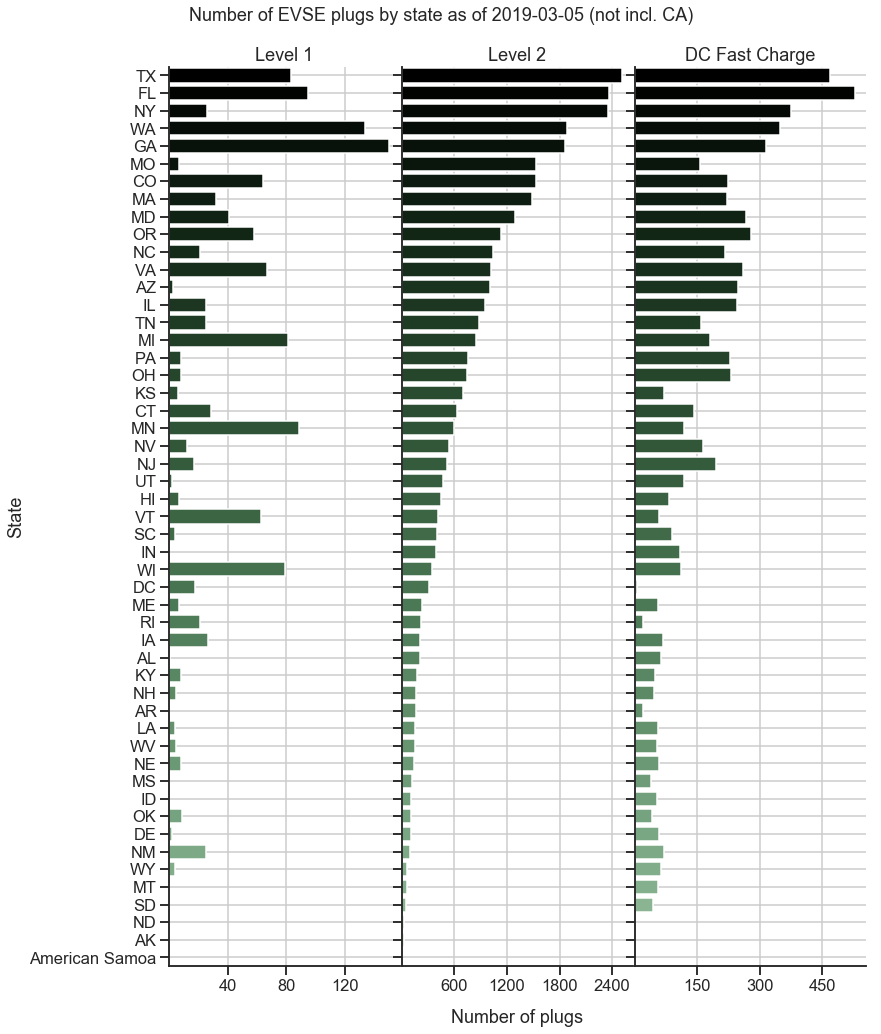

C:\Users\EBarnard\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's Webscraper


In [26]:
graph_bool = False
if search_date.weekday() == scraper_sched['AFV']:
    try:
        # Go into EVSE directory.  This directory should be in the same directory as News_scraper.ipynb. This directory must contain EVSE Market Analysis.ipynb
        %cd EVSE 
        cwd = os.getcwd()
        print(cwd)
        #!jupyter "EVSE Market Analysis.ipynb" --to script
        %run "EVSE Market Analysis.ipynb"
        # Get CA_shares from all_CA_shares.csv
        CA_shares_data = pd.read_csv(cwd + '\\' + 'all_CA_shares.csv', ';')[['date', 'text']]
        CA_shares_data.set_index('date', inplace = True)
        
        EVSE_file_dict = {
            'EVSE_bar_chart' : cwd + '\\'+ f'EVSE_bar_chart_{search_date_str}.png', # Get bar chart
        # delt_stations_tables = '',
             'CA_shares' : CA_shares_data.loc[search_date_str]['text'] # Get CA shares from today
        }
        graph_bool = True # Means all the necessary files are in the directory. If false, graphs will not be added to the docx
    except:
        print('There is a problem with one of the files.  The possibilities are:')
        print('\t1. ' + "alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=14)).strftime("%B %d %Y")) + 'is not in the EVSE folder.')
        print('\t2. ' + "alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=7)).strftime("%B %d %Y")) + 'is not in the EVSE folder.')
        print('\t3. all_CA_shares.csv is not in the EVSE folder.')
        print('\t4. ' + search_date_str + ' is not in the all_CA_shares.csv file.')
%cd ..

## Create Word file from the news update spreadsheets
Automatically does CAV on Mondays, AFV on Wednesdays, and 21CTP on Fridays. 

In [25]:
cwd = os.getcwd()
if search_date.weekday() == scraper_sched['AFV']:
    print('AFV')
    word_filename = cwd + '/'+ gen_docx('AFV', graph_bool)
elif search_date.weekday() == scraper_sched['CAV']:
    print('CAV')
    word_filename = cwd + '/'+ gen_docx('CAV')
elif search_date.weekday() == scraper_sched['21CTP']:
    print('21CTP')
    word_filename = cwd + '/'+ gen_docx('21CTP')
os.startfile(word_filename)

AFV


## Update news item tracking and news scraper meta-data databases
Only run when **final** news item spreadsheet is saved in your working directory (i.e., after you have manually added other articles to the already-saved spreadsheet from the cell above)

In [17]:
# This is in case you go to upload this week's news items to the database, and realize you forgot to do last week's. Just replace
# all instances of "search_date_str" in the next cell with "last_week"and run it. Make sure you switch them all back to "search_date_str"..
last_week = str((pd.to_datetime(search_date_str) - dt.timedelta(days=7)).date())

In [18]:
conn = sqlite3.connect('news_updates.db')
if (search_date.weekday() == scraper_sched['CAV']) & (~db_update):
    print('CAV')
    pd.read_excel('cav_news_updates/{}_cav_news_download.xls'.format(search_date_str)
                  ).to_sql('CAV', conn, if_exists='append', index=False)
    db_update = True
elif (search_date.weekday() == scraper_sched['AFV']) & (~db_update):
    print('AFV')
    pd.read_excel('afv_news_updates/{}_afv_news_download.xls'.format(search_date_str)
                  ).to_sql('AFV', conn, if_exists='append', index=False)
    db_update = True
conn.close()

# This saves the meta-data from all of the scraper runs every Wednesday (print out "scrape_specs_df" to see what the meta-data includes)
if search_date.weekday() == 2:
    conn = sqlite3.connect('news_updates_meta.db')
    scrape_specs_df.drop(['Time spent', 'Time per relevant article'], axis=1).to_sql(
        'news_updates_meta', conn, if_exists='append', index=False)
    conn.close()
    print('Uploaded metadata! So many datas!')

AFV
Uploaded metadata! So many datas!


C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


## Halt run all

In [19]:
assert False #Will generate an error and stop notebook execution

AssertionError: 

## Academic articles scraper (**NOTE** I only run this for CAVs, so only on Mondays)
Dumps all recently-published articles (in the past week) and their abstracts into a word file. Only does a few journals right now. Check your working directory for a file called *{date} papers.docx* after you run the cells below.

In [ ]:
def css_scraypuh(selenium_dict_value):
    '''
    bad_egg: Missing a key component (usually abstract), so skip printout/tracking
    still_more: Date is still within past week, continue scraping!
    '''
    max_age = 7 # take this out
    scraped_count = 0
    papers = {}
    
    # Important -- otherwise variables could be referenced before assignment.
    title = ''
    date = ''
    summary = ''
    
    if type(selenium_dict_value['url']) != list:
        selenium_dict_value['url'] = [selenium_dict_value['url']]
    for url in selenium_dict_value['url']:
        load_count = 0
        still_more = True
    
        driver.get(url)
        soup = BeautifulSoup(driver.page_source, "html5lib")
    
        # Click on CSS element to load more articles if available.
        if selenium_dict_value['load_more_css'] != None:
            for loadNo in range(selenium_dict_value['max_loads']):
                driver.find_element_by_css_selector(selenium_dict_value['load_more_css']).click()
            soup = BeautifulSoup(driver.page_source, "html5lib")
        papers_to_scrape = eval(selenium_dict_value['url_list_query'])
        
        for paper in papers_to_scrape:
            bad_egg = False
            if not still_more or scraped_count > selenium_dict_value['max_scrapes']:
                break
            # Open article URL using selenium.
            driver.get(paper)
            soup = BeautifulSoup(driver.page_source, "html5lib")
            # Get article publication date, title, and summary.
            try:
                # Click on CSS element to reveal the location of the publication date if needed.
                if selenium_dict_value['date_css'] != None:
                    driver.find_element_by_css_selector(selenium_dict_value['date_css']).click()
                    soup = BeautifulSoup(driver.page_source, "html5lib")
                # Scrape the publication date.
                date = eval(selenium_dict_value['date_loc'])
                date = dt.datetime.strptime(date, selenium_dict_value['date_format']).date()
                # If the publication date shows the article is more recent than than max_age (in days) OR if articles are not 
                # ordered by date (as in the case of Detroit News) scrape the title and summary.
                too_old = ((date - search_date).days <= -max_age)
                if not too_old:
                    # Click on CSS element to reveal the location of the title if needed.
                    if selenium_dict_value['title_css'] != None:
                        driver.find_element_by_css_selector(selenium_dict_value['title_css']).click()
                        soup = BeautifulSoup(driver.page_source, "html5lib")
                    # Scrape and clean the title.
                    title = eval(selenium_dict_value['title_loc'])
                    title = replace_em(title)
                    # Click on CSS element to reveal the location of the summary if needed.
                    if selenium_dict_value['sum_css'] != None:
                        driver.find_element_by_css_selector(selenium_dict_value['sum_css']).click()
                        soup = BeautifulSoup(driver.page_source, "html5lib")
                    # Scrape and clean the summary.
                    summary = clean_summary(eval(selenium_dict_value['sum_loc'])) # Assumes that eval(...) results in a list of paragraphs.
                    #summary = ' '.join([replace_em(p.text) for p in summary]) 
                    scraped_count += 1 
                    papers[scraped_count] = {
                            'title': title, 'summary': summary, 'link': paper, 
                            'source': selenium_dict_value['source'], 'date': date}
                    
                # If article is too old, set still_more = False (if articles are ordered by date).  
                # This will break out of the for loop so that paypuh_scraypuh() stops scraping papers from this source.
                else:
                    if selenium_dict_value['ordered_bool']:
                        still_more = False
            
            except Exception as e:
                bad_egg = True
                #print('bad egg in {}: {}'.format(selenium_dict_value['source'], paper))
                # Print out exception info.
                #print('Exception info: ', sys.exc_info(), '\n')
                pass
            
            
    # Print the number of papers scraped from each source.
    print('{} new papers in {}'.format(scraped_count, selenium_dict_value['source']))
    return pd.DataFrame(papers).T

In [ ]:
# sum_loc must provide directions for finding a list of paragraphs (not just paragraph text).
selenium_dict = {
                   # 'Detroit News': {'url': 'https://www.detroitnews.com/autos/',
                    #                 'source': 'Detroit News',
                     #                'url_list_query': "['https://www.detroitnews.com' + a['href'] for a in soup.find('div', class_='headline-page active').find_all('a')]",
                      #               #'load_more_css': "a.button-add-content",
                       #              'load_more_css': None,
                        #             'max_scrapes': 30,
                         #            #'max_loads': 2, # Make sure that loads is not too many -- otherwise load button may become inactive.  Test this.
                          #           'max_loads': None,
                           #          'ordered_bool': False,
                            #         'date_css': None,
                             #        'date_loc': "soup.find('span', class_='asset-metabar-time asset-metabar-item nobyline').text.split('ET ')[1].split(' |')[0]",
                              #       'date_format': '%b. %d, %Y',
                               #      'sum_css': None,
                                #     'sum_loc': "[soup.find('p', class_='speakable-p-1 p-text'), soup.find('p', class_='speakable-p-2 p-text')]",
                                 #    'title_loc': "soup.find('h1', class_='asset-headline speakable-headline').text",
                                  #   'title_css': None},
                                 
                        'Transportation Research': {'url': ['https://www.journals.elsevier.com/transportation-research-part-a-policy-and-practice/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-b-methodological/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-c-emerging-technologies/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-d-transport-and-environment/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-e-logistics-and-transportation-review/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-f-traffic-psychology-and-behaviour/recent-articles' 
                                                           ],
                                     'source': 'Transportation Research',
                                     'url_list_query': "[div.a['href'] for div in soup.find_all('div', class_='pod-listing-header')]",
                                     'load_more_css': None,
                                     'max_scrapes': 100,
                                     'max_loads': None,
                                     'ordered_bool': True,
                                     'date_css': "button.show-hide-details",
                                     'date_loc': "soup.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                     'date_format': '%d %B %Y',
                                     'sum_css': None,
                                     'sum_loc': "soup.find('div', class_='abstract author').find_all('p', limit = 2)",
                                     'title_loc': "soup.h1.text",
                                     'title_css': None},
    
                            'Journal of Urban Economics': {'url': 'https://www.journals.elsevier.com/journal-of-urban-economics/recent-articles',
                                     'source': 'Journal of Urban Economics',
                                     'url_list_query': "[div.a['href'] for div in soup.find_all('div', class_='pod-listing-header')]",
                                     'load_more_css': None,
                                     'max_scrapes': 100,
                                     'max_loads': None,
                                     'ordered_bool': True,
                                     'date_css': "button.show-hide-details",
                                     'date_loc': "soup.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                     'date_format': '%d %B %Y',
                                     'sum_css': None,
                                     'sum_loc': "soup.find('div', class_='Abstracts').find_all('p', limit = 3)",
                                     'title_loc': "soup.h1.text",
                                     'title_css': None},
    
                            'Transport Policy': {'url': 'https://www.journals.elsevier.com/transport-policy/recent-articles',
                                     'source': 'Transport Policy',
                                     'url_list_query': "[div.a['href'] for div in soup.find_all('div', class_='pod-listing-header')]",
                                     'load_more_css': None,
                                     'max_scrapes': 100,
                                     'max_loads': None,
                                     'ordered_bool': True,
                                     'date_css': "button.show-hide-details",
                                     'date_loc': "soup.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                     'date_format': '%d %B %Y',
                                     'sum_css': None,
                                     'sum_loc': "soup.find('div', class_='Abstracts').find_all('p', limit = 3)",
                                     'title_loc': "soup.h1.text",
                                     'title_css': None}
                                     }

In [ ]:
driver = webdriver.Chrome()
week_o_papers = []
for site in selenium_dict:
    week_o_papers.append(css_scraypuh(selenium_dict[site]))
week_o_papers = pd.concat(week_o_papers)
#week_o_papers.to_excel('{} papers.xls'.format(search_date_str))
week_o_papers.dropna(how='all', axis=0, inplace=True)

In [ ]:
newsdoc = docx.Document(docx='python_docx.docx')

for row in week_o_papers.reset_index(drop=True).T:
    row = week_o_papers.iloc[row, :]
    newsdoc.add_heading(row['title'], level=2);
    p = newsdoc.add_paragraph(row['summary'] + ' ')
    p.add_run('(');
    add_hyperlink(p, '{}'.format(row['link']), '{}'.format(row['source']));
    p.add_run(')');
newsdoc.save('{} papers.docx'.format(search_date_str));

In [ ]:
conn = sqlite3.connect('news_papers.db')
week_o_papers.to_sql('news_papers', conn, if_exists='append', index=False)
conn.close()

# For scraper testing (no need to run)

## Testing a single news scraper

For testing a single scraper - only needed when adding new sites (don't want to run all of them over and over...)

In [ ]:
scrape_specs = {}
scraypahs = {}
temp_start_time = time.time()

name = 'CNET'
scraypahs[name] = scraypah(scraper_dict[name])
scraypahs[name].get_urls()
scraypahs[name].scrape_em()
scrape_specs = print_results(scraypahs[name].source, scraypahs[name].scraped_count, scraypahs[name].skip_count,
                             scraypahs[name].too_old, scraypahs[name].relevant_df, round(
                                 time.time()-temp_start_time, 2),
                             scrape_specs)

## Testing css_scraypuh

In [ ]:
driver = webdriver.Chrome()
df = css_scraypuh(selenium_dict['Transportation Research'])

# For scraper development (no need to run)

In [ ]:
headers

In [ ]:
url = 'https://venturebeat.com/2018/09/19/renault-unveils-autonomous-delivery-concept-ez-pro-with-customizable-robo-pods/'
page = requests.get(url, headers = headers)
soup = BeautifulSoup(page.content, 'html5lib')

In [ ]:
[item for item in soup.find('div', class_ = ['the-content','article-content']).find_all('p')]

In [ ]:
[p for p in soup.find_all('p') if p.text and len(p.text)>10]

In [ ]:
'strain_tag':'a', 
'strain_attr_name':'class', 
'strain_attr_value':'post-block__title__link',

In [ ]:
test_dict = {'url':'https://venturebeat.com/category/transportation/', 
                                 'source': 'Venture Beat', 
                                 'url_list_query':"[item.a['href'] for item in self.base_soup.select('h2.article-title')]+[item.a['href'] for item in self.base_soup.select('article')]",
                                 'date_loc': "article.find('meta', attrs={'property':'article:published_time'})['content']", 
                                 'date_format':None,
                                 'sum_loc': "[p for p in article.find('div', class_ = ['the-content','article-content']).find_all('p')]",
                                 'title_loc':"article.find('h1').text", 
                                 'strain_bool':False}

In [ ]:
scraper = scraypah(test_dict)
scraper.get_urls()
scraper.urls_to_scrape

In [ ]:
def test_a_scraypah(attr_dict):
    start = time.time()
    scraper = scraypah(attr_dict)
    print(time.time()-start)
    scraper.get_urls()
    print(time.time()-start)
    scraper.scrape_em()
    print(time.time()-start)
    return scraper

In [ ]:
with pd.option_context('display.max_colwidth', 100):
    print(ttopics.relevant_df['title'])

In [ ]:
ttopics.relevant_df['summary'][0]

In [ ]:
ttopics = test_a_scraypah(test_dict)

### Unused scrapers

In [ ]:
'Engadget': {'url': ['https://www.engadget.com/tags/transportation/', 'https://www.engadget.com/tag/transportation/page/2/'],
                             'source': 'Engadget',
                             'strain_tag': 'a',
                             'strain_attr_name': 'class',
                             'strain_attr_value': 'o-hit__link',
                             'url_list_query': "['https://www.engadget.com'+item['href'] for item in self.base_soup.find_all('a', attrs={'class':'o-hit__link'})]",
                             'date_loc': "article.find('meta', attrs={'name':'published_at'})['content']",
                             'date_format': None,
                             'sum_loc': "article.find('div', attrs={'class':'container@m-'}).find_all('p')",
                             'title_loc': "article.title.text",
                             'strain_bool': True},
'NGV Global': {'url': 'http://www.ngvglobal.com/',
                               'source': 'NGV Global',
                               'strain_tag': 'h2',
                               'strain_attr_name': 'class',
                               'strain_attr_value': 'entry-title',
                               'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h2', attrs={'class':'entry-title'})]",
                               'date_loc': "article.find('time')['title']",
                               'date_format': None,
                               'sum_loc': "article.find('div', attrs={'class':'pf-content'}).find_all('p')",
                               'title_loc': "article.find('h1', attrs={'class':'entry-title'}).text",
                               'strain_bool': True},

# Change Log
* 8/29/2018: Added Citylab, Electrek, cleaned code
* 8/7/2018: Added Transport Reviews to academic paper scraper
* 7/30/2018: Fixed GovTech scraper
* 6/29/2018: Changed the whole scraper over to utilize a new class called *scraypah*. 
* 5/12/2018: Added Semiconductor Engineering scraper and academic articles scraper (~3 hours)
* 4/13/2018: Integrated word document production through python
* 3/19/2018: Added OEM/Gov section that quickly checks 17 sites for updates - only prints a notification that it needs to be checked if there are new updates from the past week
* 2/27/2018: Wrote a function *page_scan* to more efficiently create the relevant web page dictionary "profiles"
* 2/27/2018: Added 21CTP trucking news keywords to search for. Integrated functionality into existing web scraper.
* 2/14/2018: Added NGV Global scraper for AFV stuff
* 2/14/2018: Added fuel cells, hybrid, hybrid-electric, 'electric buses', 'electric truck', 'electric trucks', 'electric drive' to the search terms for AFVs...
* 1/31/2018: Added *print_results* function to streamline printed results for each scraper. Added counter to track #articles that were too old. Added meta-data tracking capability (dumps into SQL database every week)
* 1/31/2018: Split EV market analysis and web scraper into two different Notebooks
* 1/26/2018: Added Lexology scraper
* 1/19/2018: Fixed GreenCarCongress scraper (site redesign)
* 1/4/2018: Added Engadget scraper
* 1/4/2018: Added "replace_em" function to streamline removal of meaningless substrings from body text summaries
* 12/29/2017: Added Reuters, MITNews, and ARSTechnica scrapers. Did some streamlining in the EV Sales analysis
* 12/20/2017: Wrote up quick-guide to all the post-Python processing needed for the final News Update doc.
* 12/20/2017: Changed to .xls format. Had to import a different package to do so, but makes mail merge work better
* 12/13/2017: Fixed Trucks.com scraper - was pulling out the wrong date for each article (pulled a date from the sidebar...)
* 12/8/2017: Edited Trucks.com search so that it doesn't pick up paragraph tags that are actually image captions (added condition that "class = None")
* 12/8/2017: Added a bunch of comments, specifically in the first code segment ("IEEE Spectrum") for explanatory purposes
* 1/8/2019: Added Green Car Reports, DOE, Business Wire, and The Fuse.
* 1/10/2019: Uploaded ipynb to Energetics' GitHub (EICode).  Log entries can now be found via GitHub.